In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
import time
from imblearn.over_sampling import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datosreales/DatosReales.csv
/kaggle/input/datasetheartdisease/dataset.csv


# Visualización inicial de los datos

In [2]:
data=pd.read_csv("/kaggle/input/datasetheartdisease/dataset.csv")
df=data.copy()
df=df.drop(["Unnamed: 0"],axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,8,17,1,1,5,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,8,22,0,1,5,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,9,19,1,1,3,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,8,21,0,0,4,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,8,14,0,1,5,8.0,0,0,0


In [3]:
df = df.sample(frac=0.01)
df.shape

(3198, 17)

# Separamos los datos
Separamos los datos de nuestro dataset, ponemos las características que vamos a utilizar para entrenar en la variable X y la variable a predecir en la varibale Y.

In [4]:
X=df.iloc[:,1:17]
Y=df.iloc[:,0]

# Estandarización de los datos
Usamos StandardScaler para estandarizar las caracteríticas que vamos a usar para entrenar en nuestro modelo.

In [5]:
scaler=StandardScaler()
columns=X.columns
s=scaler.fit_transform(X)

X=pd.DataFrame(s,columns=columns)
X.head(5)

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,3.905583,1.200509,-0.275102,-0.213166,2.804882,3.367280,-0.409365,-0.942252,-1.289683,-0.386160,-1.848547,-1.551370,-0.805430,-0.390426,-0.190507,-0.32056
1,-0.238013,-0.832980,-0.275102,-0.213166,-0.417244,-0.485515,-0.409365,-0.942252,0.668591,-0.386160,0.540965,0.395376,-1.530181,-0.390426,-0.190507,-0.32056
2,0.129994,1.200509,-0.275102,-0.213166,-0.417244,0.311615,-0.409365,1.061287,0.109085,2.589599,0.540965,-0.577997,0.644072,-0.390426,5.249150,-0.32056
3,0.075184,-0.832980,-0.275102,-0.213166,-0.159474,0.843035,-0.409365,1.061287,-1.849189,-0.386160,0.540965,0.395376,-1.530181,-0.390426,-0.190507,-0.32056
4,-0.443157,1.200509,-0.275102,-0.213166,3.449308,3.500135,2.442810,-0.942252,0.668591,2.589599,0.540965,-2.524744,-0.805430,-0.390426,-0.190507,-0.32056


# Submuestro de los datos con Oversampling

In [6]:
subsample=RandomOverSampler()
X_new, Y_new=subsample.fit_resample(X,Y)
print("Dimensiones")
print("Xtrain_new: ", X_new.shape)
print("Ytrain_new: ", Y_new.shape)


Dimensiones
Xtrain_new:  (5836, 16)
Ytrain_new:  (5836,)


# Función Selección de características
Función utilizada para declarar Sequential Feature Selector con la cantidad de caracteristicas a selecciona y el modelo que va a utilizar

In [7]:
def select_features(model,n_features,fwd):
    sfs=SFS(
        model,
        k_features=n_features,
        forward=fwd,
        scoring='accuracy',
        cv=0
    )
    return sfs

# Selección de caracteríticas
Se declara la función train_select_features que lo que hace es por medio de StratifiedKFold y un array con la cantidad de caracteríticas a seleccionar, entrena un modelo y guardar el rendimiento en un dataframe para luego seleccionar con que y cuales caracteríticas tuvo mejor rendimieto el modelo.

In [8]:
def train_select_features(model,folds,features,X,Y):
    skf=StratifiedKFold(n_splits=folds)
    resultados=pd.DataFrame()
    idx=0
    resultados = {
        'Modelo': [],
        'Features':[],
        'Name Features':[],
        'Index Features':[],
        'Error':[],
        'Tiempo':[]
    }
    for feature in features:
        for train, test in skf.split(X=X,y=Y):
            tiempo_i = time.time()
            Xtrain, Xtest = X.iloc[train], X.iloc[test]
            Ytrain, Ytest = Y[train], Y[test]
            
            model_train=select_features(model,feature,False)
            model_train.fit(Xtrain,Ytrain)
            tiempo_f = time.time()
            resultados['Modelo'].append(str(model))
            resultados['Name Features'].append(model_train.k_feature_names_)
            resultados['Index Features'].append(model_train.k_feature_idx_)
            resultados['Features'].append(feature)
            resultados['Error'].append(1-model_train.k_score_)
            resultados['Tiempo'].append(tiempo_f-tiempo_i)



    return resultados

In [9]:
hidden_layer_sizes = tuple(10*[100])
model=MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,activation='tanh',max_iter=350, random_state = 1)

In [10]:
features=[4,8,12]
resultados=train_select_features(model,3,features,X_new,Y_new)
resultados= pd.DataFrame.from_dict(resultados, orient='index')
resultados=resultados.transpose()
resultados

,Modelo,Features,Name Features,Index Features,Error,Tiempo
0,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.059897,6064.146848
1,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, Sex, AgeCategory, SleepTime)","(0, 7, 8, 12)",0.093806,6043.777
2,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.056027,6321.687587
3,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, Sex, AgeCategory, GenHealth, Sl...","(0, 1, 7, 8, 11, 12, 13, 15)",0.009254,4417.362694
4,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, DiffWalking, Sex, AgeCategory, ...","(0, 1, 6, 7, 8, 11, 12, 15)",0.012079,4758.51519
5,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, PhysicalHealth, DiffWalking, Sex, AgeCat...","(0, 4, 6, 7, 8, 9, 11, 12)",0.014906,5397.970855
6,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, Stroke, PhysicalHealth, DiffWal...","(0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.002828,2960.951273
7,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, AlcoholDrinking, PhysicalHealth...","(0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.003855,3042.855758
8,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Stroke, PhysicalHealth, MentalHealth, Di...","(0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)",0.006425,3055.241692


# Gráfica de los resultados obtenidos

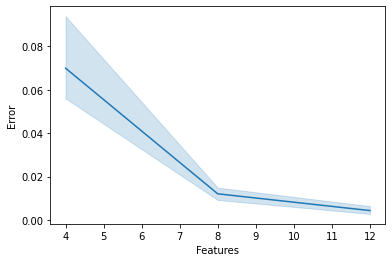

In [11]:
sns.lineplot(data=resultados,x="Features",y="Error")
plt.show()

In [12]:
resultados.sort_values(by ='Error', ascending =True).head(10)

,Modelo,Features,Name Features,Index Features,Error,Tiempo
6,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, Stroke, PhysicalHealth, DiffWal...","(0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.002828,2960.951273
7,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, AlcoholDrinking, PhysicalHealth...","(0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.003855,3042.855758
8,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Stroke, PhysicalHealth, MentalHealth, Di...","(0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)",0.006425,3055.241692
3,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, Sex, AgeCategory, GenHealth, Sl...","(0, 1, 7, 8, 11, 12, 13, 15)",0.009254,4417.362694
4,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, DiffWalking, Sex, AgeCategory, ...","(0, 1, 6, 7, 8, 11, 12, 15)",0.012079,4758.51519
5,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, PhysicalHealth, DiffWalking, Sex, AgeCat...","(0, 4, 6, 7, 8, 9, 11, 12)",0.014906,5397.970855
2,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.056027,6321.687587
0,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.059897,6064.146848
1,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, Sex, AgeCategory, SleepTime)","(0, 7, 8, 12)",0.093806,6043.777


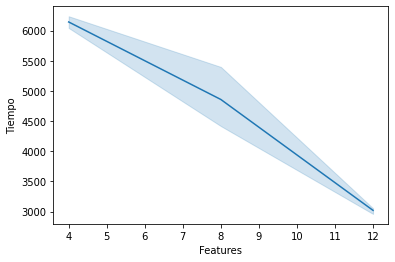

In [13]:
sns.lineplot(data=resultados,x="Features",y="Tiempo")
plt.show()

In [14]:
resultados.sort_values(by ='Tiempo', ascending =True).head(10)

,Modelo,Features,Name Features,Index Features,Error,Tiempo
6,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, Stroke, PhysicalHealth, DiffWal...","(0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.002828,2960.951273
7,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Smoking, AlcoholDrinking, PhysicalHealth...","(0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 13, 15)",0.003855,3042.855758
8,"MLPClassifier(activation='tanh',\n ...",12,"(BMI, Stroke, PhysicalHealth, MentalHealth, Di...","(0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14)",0.006425,3055.241692
3,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, Sex, AgeCategory, GenHealth, Sl...","(0, 1, 7, 8, 11, 12, 13, 15)",0.009254,4417.362694
4,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, Smoking, DiffWalking, Sex, AgeCategory, ...","(0, 1, 6, 7, 8, 11, 12, 15)",0.012079,4758.51519
5,"MLPClassifier(activation='tanh',\n ...",8,"(BMI, PhysicalHealth, DiffWalking, Sex, AgeCat...","(0, 4, 6, 7, 8, 9, 11, 12)",0.014906,5397.970855
1,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, Sex, AgeCategory, SleepTime)","(0, 7, 8, 12)",0.093806,6043.777
0,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.059897,6064.146848
2,"MLPClassifier(activation='tanh',\n ...",4,"(BMI, AgeCategory, GenHealth, SleepTime)","(0, 8, 11, 12)",0.056027,6321.687587


# Función para el entrenamiento de los modelos

In [15]:
def entrenarModelo(model_train, Xtrain,Ytrain,Xtest,Ytest):
    model.fit(X=Xtrain,y=Ytrain)
    Ypred=model.predict(Xtest)

    print(f'Model: {str(model)}')
    print(f'Accuracy Score: {accuracy_score(Ytest,Ypred)}')
    print(f'Recall Score: {recall_score(Ytest,Ypred)}')
    print(f'F1-Score: {f1_score(Ytest,Ypred)}')
    cm = confusion_matrix(Ytest, Ypred, labels=model_train.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_train.classes_)
    disp.plot()
    return model_train

# Función para la validación del modelo con datos reales

In [16]:
def validarModelo(model, X, Y):
  y_pred=model.predict(X)
  print("Accuracy:",accuracy_score(Y, y_pred))
  print(f'Precission Score: {precision_score(Y,y_pred)}')
  print(f'Recall Score: {recall_score(Y,y_pred)}')
  print(f'F1-Score: {f1_score(Y,y_pred)}')
  cm = confusion_matrix(Y, y_pred, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot()

# Función para seleccionar la data
Esta función se encarga de extraer del dataframe original las caracteríticas seleccionadas a través de sus índices, para luego entrenar el modelo solo con esas caracteríticas seleccionadas

In [17]:
def select_data(data,index):
    return data.iloc[:,index]

# Función para particionar los datos
Partimos los datos en train y test en una proporción 70-30. 70% de los datos para entrenar el modelo y 30% de los datos para la validación del mismo.

In [18]:
def split_data(X,Y):
    return train_test_split(X,Y,test_size=0.3,random_state=50)

# Cargamos los datos reales

In [19]:
data_real=pd.read_csv("/kaggle/input/datosreales/DatosReales.csv")
df_real=data_real.copy()
df_real["BMI"] = encoder.fit_transform(df_real["BMI"])
df_real.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,1,0,0,0,0,0,0,8,10,0,0,5,6,0,0,0
1,0,4,0,0,0,0,0,0,8,10,0,1,5,6,1,0,0
2,1,8,1,0,1,25,28,1,9,20,1,0,3,9,0,1,0
3,0,5,0,0,0,0,0,0,9,10,0,0,6,6,0,0,0
4,1,12,0,1,1,30,15,1,8,18,1,0,4,4,1,1,1


In [20]:
X_real=df_real.iloc[:,1:]
Y_real=df_real.iloc[:,0]

# Modelo con 4 características seleccionadas

In [21]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][0]))
selected_data.head()

,BMI,AgeCategory,GenHealth,SleepTime
0,3.905583,-1.289683,-1.551370,-0.805430
1,-0.238013,0.668591,0.395376,-1.530181
2,0.129994,0.109085,-0.577997,0.644072
3,0.075184,-1.849189,0.395376,-1.530181
4,-0.443157,0.668591,-2.524744,-0.805430


In [22]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)

Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.8903483723586522
Recall Score: 0.9692832764505119
F1-Score: 0.8987341772151899


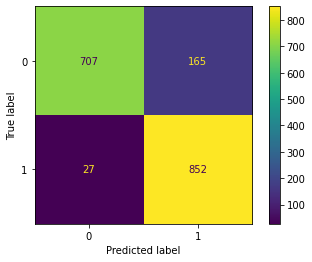

In [23]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [24]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][0]))

Accuracy: 0.8
Precission Score: 0.7
Recall Score: 1.0
F1-Score: 0.8235294117647058


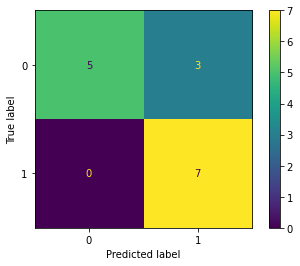

In [25]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)


# Modelo con 8 características seleccionadas


In [26]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][3]))
selected_data.head()

,BMI,Smoking,Sex,AgeCategory,GenHealth,SleepTime,Asthma,SkinCancer
0,3.905583,1.200509,-0.942252,-1.289683,-1.551370,-0.805430,-0.390426,-0.32056
1,-0.238013,-0.832980,-0.942252,0.668591,0.395376,-1.530181,-0.390426,-0.32056
2,0.129994,1.200509,1.061287,0.109085,-0.577997,0.644072,-0.390426,-0.32056
3,0.075184,-0.832980,1.061287,-1.849189,0.395376,-1.530181,-0.390426,-0.32056
4,-0.443157,1.200509,-0.942252,0.668591,-2.524744,-0.805430,-0.390426,-0.32056


In [27]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)


Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.9468874928612222
Recall Score: 1.0
F1-Score: 0.9497568881685575


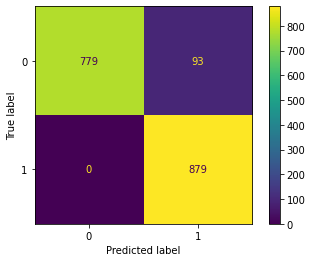

In [28]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [29]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][3]))


Accuracy: 0.5333333333333333
Precission Score: 0.0
Recall Score: 0.0
F1-Score: 0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


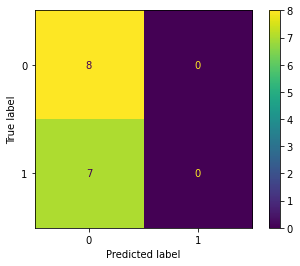

In [30]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)


# Modelo con 12 características seleccionadas

In [31]:
selected_data=select_data(X_new,np.array(resultados["Index Features"][6]))
selected_data.head()

,BMI,Smoking,Stroke,PhysicalHealth,DiffWalking,Sex,AgeCategory,Diabetic,GenHealth,SleepTime,Asthma,SkinCancer
0,3.905583,1.200509,-0.213166,2.804882,-0.409365,-0.942252,-1.289683,-0.386160,-1.551370,-0.805430,-0.390426,-0.32056
1,-0.238013,-0.832980,-0.213166,-0.417244,-0.409365,-0.942252,0.668591,-0.386160,0.395376,-1.530181,-0.390426,-0.32056
2,0.129994,1.200509,-0.213166,-0.417244,-0.409365,1.061287,0.109085,2.589599,-0.577997,0.644072,-0.390426,-0.32056
3,0.075184,-0.832980,-0.213166,-0.159474,-0.409365,1.061287,-1.849189,-0.386160,0.395376,-1.530181,-0.390426,-0.32056
4,-0.443157,1.200509,-0.213166,3.449308,2.442810,-0.942252,0.668591,2.589599,-2.524744,-0.805430,-0.390426,-0.32056


In [32]:
X_train,X_test,y_train,y_test=split_data(selected_data,Y_new)


Model: MLPClassifier(activation='tanh',
              hidden_layer_sizes=(100, 100, 100, 100, 100, 100, 100, 100, 100,
                                  100),
              max_iter=350, random_state=1)
Accuracy Score: 0.9514563106796117
Recall Score: 1.0
F1-Score: 0.9538795442213782


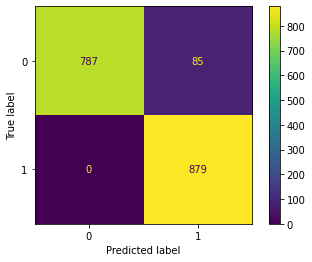

In [33]:
modelo_entrenado=entrenarModelo(model,X_train,y_train,X_test,y_test)


## Validación del modelo con datos reales

In [34]:
X_real_seleccionada=select_data(X_real,np.array(resultados["Index Features"][6]))

Accuracy: 0.8
Precission Score: 1.0
Recall Score: 0.5714285714285714
F1-Score: 0.7272727272727273


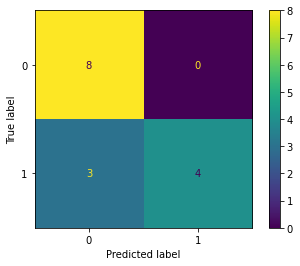

In [35]:
validarModelo(modelo_entrenado,X_real_seleccionada,Y_real)
